In [1]:
import os
from io import StringIO
from pathlib import Path

import pandas as pd

In [2]:
result_dir = Path("results")

performance_metric_file = result_dir / "benchmark.tsv"
performance_metric_sainsc_file = result_dir / "benchmark_sainsc_genes_vs_signatures.tsv"

In [3]:
result_dir.mkdir(parents=True, exist_ok=True)

In [18]:
job_ids = {
    3773887: "FICTURE (1 thread)",
    3773888: "FICTURE (8 threads)",
    3769989: "sainsc (8k genes)",
    3774459: "sainsc (20k genes)",
    3765018: "TopACT",
}

job_ids = pd.Series(job_ids, name="tool").to_frame()

In [19]:
job_stats = os.popen(
    (
        "sacct "
        f"-j {','.join(job_ids.index.astype(str))} "
        "--starttime 2024-06-25 "
        "--format='JobID,Jobname%50,TotalCPU,ElapsedRaw,MaxRSS' "
        "-P "
        "--delimiter=$'\t' "
        "--units=M "
    )
).read()

job_stats = pd.read_table(StringIO(job_stats))

In [20]:
cpu_stats = (
    job_stats.loc[
        lambda df: ~df["JobID"].str.contains(".", regex=False),
        ["JobID", "JobName", "TotalCPU", "ElapsedRaw"],
    ]
    .assign(
        JobID=lambda df: df["JobID"].astype(int),
        TotalCPU=lambda df: ("00:" + df["TotalCPU"]).str.extract(
            "(\d{2}:\d{2}:\d{2}(?:\.\d+)?)$"
        ),
    )
    .assign(
        TotalCPU=lambda df: pd.to_timedelta(df["TotalCPU"]).dt.total_seconds(),
    )
    .set_index("JobID")
    .rename(columns={"TotalCPU": "CPU time [s]", "ElapsedRaw": "wall time [s]"})
)

In [21]:
memory_stats = (
    job_stats.loc[
        lambda df: df["JobID"].str.contains(".batch", regex=False), ["JobID", "MaxRSS"]
    ]
    .assign(
        JobID=lambda df: df["JobID"].str.extract("(\d+)").astype(int),
        MaxRSS=lambda df: df["MaxRSS"].str.extract("([\d\\.]+)").astype(float),
    )
    .set_index("JobID")
    .rename(columns={"MaxRSS": "max memory [MB]"})
)

In [22]:
stats = (
    cpu_stats.join(memory_stats).join(job_ids, how="inner").drop(columns=["JobName"])
)

In [23]:
stats.to_csv(performance_metric_file, sep="\t", index=False)

In [24]:
stats_comparison = pd.read_table(performance_metric_file)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
stats_comparison = stats_comparison.assign(
    **{
        "Max memory [GB]": lambda x: x["max memory [MB]"] / 1e3,
        "Wall time [h]": lambda x: x["wall time [s]"] / 60**2,
        "CPU time [h]": lambda x: x["CPU time [s]"] / 60**2,
    }
)

In [27]:
stats_comparison

,CPU time [s],wall time [s],max memory [MB],tool,Max memory [GB],Wall time [h],CPU time [h]
0,15773.0,604814,87291.11,TopACT,87.29111,168.003889,4.381389
1,23400.0,3626,5710.78,sainsc (8k genes),5.71078,1.007222,6.500000
2,25720.0,22191,6875.73,FICTURE (1 thread),6.87573,6.164167,7.144444
3,26560.0,9187,8594.67,FICTURE (8 threads),8.59467,2.551944,7.377778
4,67219.0,9915,6648.39,sainsc (20k genes),6.64839,2.754167,18.671944


In [28]:
order = [
    "sainsc (8k genes)",
    "sainsc (20k genes)",
    "FICTURE (1 thread)",
    "FICTURE (8 threads)",
    "TopACT",
]

palette = sns.color_palette("tab10", len(order))
palette[-1] = "grey"

palette = dict(zip(order, palette))

In [29]:
stats_sainsc = pd.read_table(performance_metric_sainsc_file)

In [30]:
stats_sainsc = stats_sainsc.assign(
    **{
        "Max memory [GB]": lambda x: x["max memory [MB]"] / 1e3,
        "Wall time [min]": lambda x: x["wall time [s]"] / 60,
        "CPU time [min]": lambda x: x["CPU time [s]"] / 60,
    }
).rename(columns={"n_signatures": "# signatures", "n_genes": "# genes"})

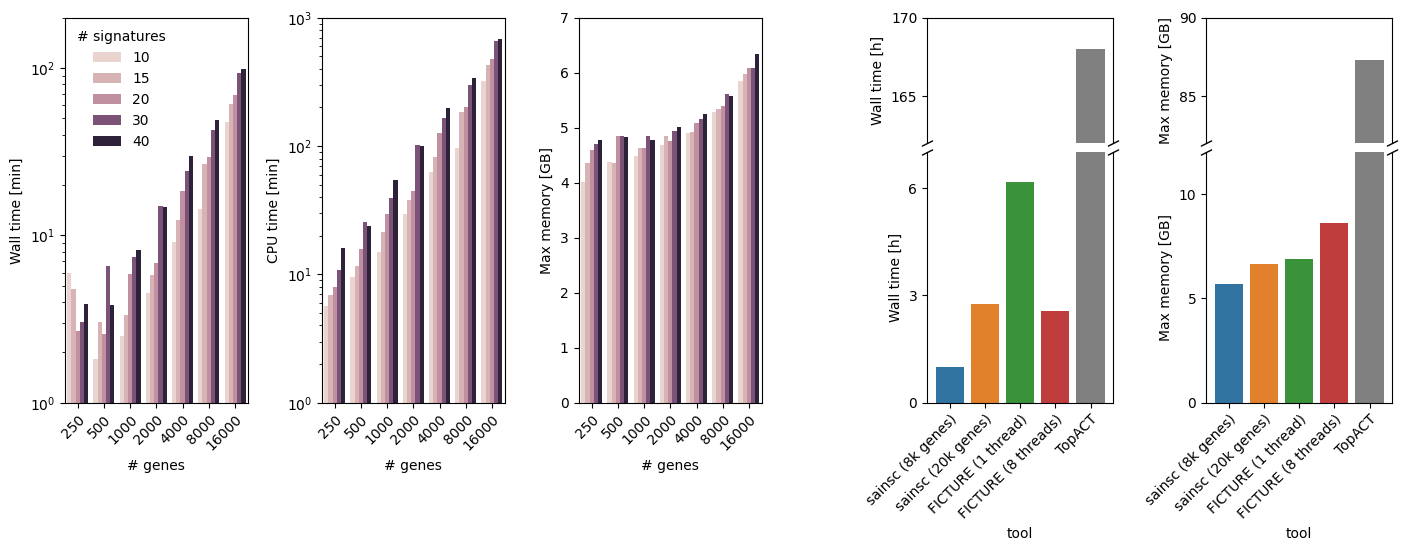

In [32]:
fig = plt.figure(figsize=(15, 5))

subfigures = fig.subfigures(1, 2, width_ratios=[3, 2])

# Sainsc bechmark
axs = subfigures[0].subplots(1, 3)
subfigures[0].subplots_adjust(wspace=0.4)

for i, metric in enumerate(["Wall time [min]", "CPU time [min]", "Max memory [GB]"]):
    legend = i == 0
    sns.barplot(
        data=stats_sainsc,
        x="# genes",
        y=metric,
        hue="# signatures",
        legend=legend,
        ax=axs[i],
    )
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor"
    )
    if legend:
        axs[i].get_legend().set(frame_on=False)

axs[0].set(ylim=(1, 200), yscale="log")
axs[1].set(ylim=(1, 1_000), yscale="log")
axs[2].set(ylim=(0, 7))

## Comparison

axs = subfigures[1].subplots(2, 2, sharex=True, height_ratios=[1, 2])
subfigures[1].subplots_adjust(hspace=0.05, wspace=0.5)

# Wall time
sns.barplot(
    data=stats_comparison,
    x="tool",
    y="Wall time [h]",
    order=order,
    hue="tool",
    ax=axs[1, 0],
    palette=palette,
)
axs[1, 0].set_ylim(0, 7)

sns.barplot(
    data=stats_comparison,
    x="tool",
    y="Wall time [h]",
    order=order,
    hue="tool",
    ax=axs[0, 0],
    palette=palette,
)
axs[0, 0].set_ylim(162, 170)

# hide the spines between ax and ax2
axs[1, 0].spines.top.set_visible(False)
axs[0, 0].spines.bottom.set_visible(False)
axs[0, 0].tick_params(axis="x", which="both", bottom=False)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=8,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
axs[0, 0].plot([0, 1], [0, 0], transform=axs[0, 0].transAxes, **kwargs)
axs[1, 0].plot([0, 1], [1, 1], transform=axs[1, 0].transAxes, **kwargs)

axs[1, 0].set_yticks([0, 3, 6])
axs[0, 0].set_yticks([165, 170])

# Memory
sns.barplot(
    data=stats_comparison,
    x="tool",
    y="Max memory [GB]",
    order=order,
    hue="tool",
    ax=axs[1, 1],
    palette=palette,
)
axs[1, 1].set_ylim(0, 12)

sns.barplot(
    data=stats_comparison,
    x="tool",
    y="Max memory [GB]",
    order=order,
    hue="tool",
    ax=axs[0, 1],
    palette=palette,
)
axs[0, 1].set_ylim(82, 90)

# hide the spines between ax and ax2
axs[1, 1].spines.top.set_visible(False)
axs[0, 1].spines.bottom.set_visible(False)
axs[0, 1].tick_params(axis="x", which="both", bottom=False)

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=8,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)
axs[0, 1].plot([0, 1], [0, 0], transform=axs[0, 1].transAxes, **kwargs)
axs[1, 1].plot([0, 1], [1, 1], transform=axs[1, 1].transAxes, **kwargs)

axs[1, 1].set_yticks([0, 5, 10])
axs[0, 1].set_yticks([85, 90])

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].set_xticks(axs[i, j].get_xticks())
        axs[i, j].set_xticklabels(
            order, rotation=45, ha="right", rotation_mode="anchor"
        )

In [33]:
fig.savefig("figures/Fig_runtime.pdf", dpi=600, bbox_inches="tight")